In [71]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
from PIL import Image
import requests
from io import BytesIO

In [37]:
from scipy.stats import ttest_1samp

In [3]:
# open the data
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=107)

# set team
team = "Sweden Women's"

# get list of games by team, either home or away
match_ids = df_match.loc[(df_match['home_team_name'] == team) | (df_match['away_team_name'] == team)]['match_id'].tolist()
#calculate number of games
no_games = len(match_ids)

# Pass Network

In [5]:
def get_pass_df(match_id):
    parser = Sbopen()
    df = parser.event(match_id)[0]
    
    # make df with successfull passes by Sweden
    # check for index of first sub
    sub = df.loc[df['type_name'] == 'Substitution'].loc[df['team_name'] == "Sweden Women's"].iloc[0]['index']
    
    mask_sweden = (df.type_name == 'Pass') & (df.team_name == "Sweden Women's") & (df.outcome_name.isnull()) & (df.index < sub) & (df.sub_type_name != 'Throw-in')
    # select columns of interest
    df_pass = df.loc[mask_sweden, ['x', 'y', 'end_x', 'end_y', 'player_name', 'pass_recipient_name']]
    # adjust so only surname of a player is presented
    df_pass['player_name'] = df_pass['player_name'].apply(lambda x: str(x).split()[-1])
    df_pass['pass_recipient_name'] = df_pass['pass_recipient_name'].apply(lambda x: str(x).split()[-1])
    
    return df_pass

In [6]:
def get_edges(df):
    scatter_df = pd.DataFrame()
    for i, name in enumerate(df['player_name'].unique()):
        passx = df.loc[df['player_name'] == name]['x'].to_numpy()
        recx = df.loc[df['pass_recipient_name'] == name]['end_x'].to_numpy()
        passy = df.loc[df['player_name'] == name]['y'].to_numpy()
        recy = df.loc[df['pass_recipient_name'] == name]['end_y'].to_numpy()
        scatter_df.at[i, 'player_name'] = name
        
        # x and y location for each circle represents the player's average passes and receptions
        scatter_df.at[i, 'x'] = np.mean(np.concatenate([passx, recx]))
        scatter_df.at[i, 'y'] = np.mean(np.concatenate([passy, recy]))
        #calculate number of passes
        scatter_df.at[i, 'no'] = df.loc[df['player_name'] == name].count().iloc[0]

    #adjust the size of a circle based on nbr of passes
    scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)
    
    return scatter_df

In [7]:
def get_vertices(df, min_passes=0):
    # count passes between players
    lines_df = df.groupby(['player_name', 'pass_recipient_name']).count().x.reset_index()
    lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
    
    # set treshold
    lines_df = lines_df[lines_df['pass_count'] > min_passes]
    
    return lines_df

In [84]:
def plot_passing_network(df_pass, key_player):
    
    scatter_df = get_edges(df_pass)
    lines_df = get_vertices(df_pass, 5)
    
    # draw pitch
    pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    
    # scatter the location on the pitch
    pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='yellow', 
                  edgecolors='darkblue', linewidth=1, alpha=1, ax=ax["pitch"], zorder=3)

    #annotate player name
    for i, row in scatter_df.iterrows():
        pitch.annotate(row.player_name, xy=(row.x, row.y), color='black', 
                       va='center', ha='center', weight='bold', size=16, alpha=1, ax=ax['pitch'], zorder=4)

    for i, row in lines_df.iterrows():
        player1 = row['player_name']
        player2 = row['pass_recipient_name']

        # take the average location of players to plot a line between them 
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row['pass_count']

        # adjust the line width to number of passes
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        
        #plot lines on the pitch
        color = 'blue' if key_player in [player1, player2] else 'lightgray'
        alpha = 1 if key_player in [player1, player2] else 0.3
        
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                            alpha=alpha, lw=line_width, zorder=2, color=color, ax=ax['pitch'])
        
        
    # add photo of player
    ax2 = fig.add_axes([0.8,0.95,0.15,0.15])
    ax2.axis('off')
    url = 'https://b.fssta.com/uploads/application/soccer/headshots/91318.vresize.350.350.medium.13.png'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    ax2.imshow(img)
    
    # set titles
    fig.text(0.05,0.95,f'Aggregated Passing Network for Sweden\n', fontsize=26, fontweight='bold')
    fig.text(0.05,0.95,"2023 FIFA Women's World Cup", fontsize=20, fontweight="regular")
   
    fig.text(0.05, 0.05, 'Until first substitution of every game. | Minimum 5 passes.', 
             fontsize=14, color='white', fontstyle='italic', fontweight='regular')

    fig.text(0.05, -0.0, 'Data from Statsbomb \n',
        fontstyle='italic',fontsize=10, color='gray')
    fig.text(0.05, -0.0, 'Created by Olof Ekborg-Tanner (@olofekborg).',
        fontstyle='italic',fontsize=10, color='gray')
    
    #plt.savefig('pass_network.png', bbox_inches='tight')
    
    plt.show()
    
    
    return None

In [85]:
# get all passes in tourmenent
df_pass_tot = pd.DataFrame()

for match_id in match_ids:
    if match_id == 3893830:
        pass  # Ignonre match vs Argentina as the team was heavily rotated
    else:
        df_pass = get_pass_df(match_id)
        df_pass_tot = pd.concat([df_pass_tot, df_pass], ignore_index=True)

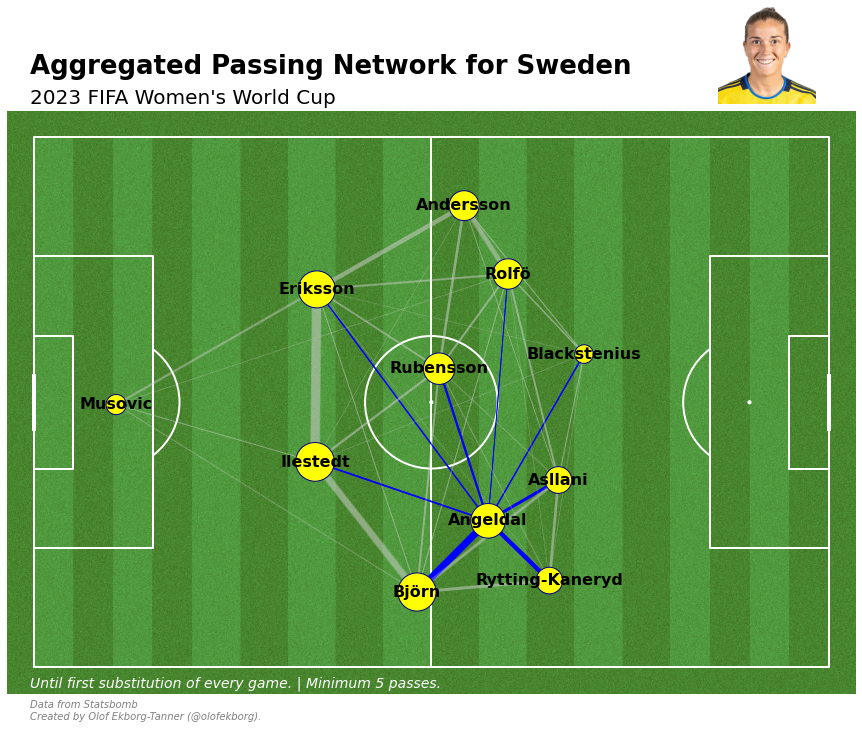

In [86]:
plot_passing_network(df_pass_tot, 'Angeldal')

### Statistical testing

In [38]:
key_player_name = 'Angeldal'

In [34]:
# most passes made in Sweden's team
df_pass_tot.groupby(['player_name']).x.count().reset_index().sort_values(by='x', ascending=False)

,player_name,x
6,Ilestedt,229
3,Björn,222
5,Eriksson,209
1,Angeldal,183
9,Rubensson,151
8,Rolfö,141
0,Andersson,137
2,Asllani,109
10,Rytting-Kaneryd,108
7,Musovic,62


In [41]:
passes_from = df_pass_tot.groupby(['player_name']).x.count().reset_index()

angeldal_from = passes_from.loc[passes_from.player_name == key_player_name].x.iloc[0]

t, pvalue = ttest_1samp(passes_from.x, angeldal_from, alternative='less')

if pvalue < 0.05:
    print(f'P-value = {pvalue} - We reject null hypothesis - {key_player_name} made more passes than team average.')
else:
    print(f'P-value = {pvalue}  - We do not reject null hypothesis - {key_player_name} did NOT make more passes than team average.')

P-value = 0.0713104024935802  - We do not reject null hypothesis - Angeldal did NOT make more passes than team average.


In [36]:
# most passes received in Sweden's team
df_pass_tot.groupby(['pass_recipient_name']).x.count().reset_index().sort_values(by='x', ascending=False)

,pass_recipient_name,x
3,Björn,230
5,Eriksson,209
6,Ilestedt,202
1,Angeldal,197
0,Andersson,138
8,Rolfö,138
2,Asllani,136
10,Rytting-Kaneryd,125
9,Rubensson,116
4,Blackstenius,83


In [59]:
passes_to = df_pass_tot.groupby(['pass_recipient_name']).x.count().reset_index()

angeldal_to = passes_to.loc[passes_to.pass_recipient_name == key_player_name].x.iloc[0]

t, pvalue = ttest_1samp(passes_to.x, angeldal_to, alternative='less')

if pvalue < 0.05:
    print(f'P-value amounts to, {pvalue}, - We reject null hypothesis - {key_player_name} received more passes than team average.')
else:
    print(f'P-value amounts to, {pvalue},  - We do not reject null hypothesis - {key_player_name} did NOT receive more passes than team average.')

P-value amounts to, 0.008791777644404114, - We reject null hypothesis - Angeldal received more passes than team average.


# Heat map

## Ball recovieries

In [60]:
# get all ball recoveries in tourmenent
df_rec_tot = pd.DataFrame()

for match_id in match_ids:
    parser = Sbopen()
    df = parser.event(match_id)[0]

    df_rec = df.loc[(df.team_name == team) & (df.type_name == 'Ball Recovery'), ['x','y','player_name','match_id']]
    
    df_rec_tot = pd.concat([df_rec_tot, df_rec], ignore_index=True)

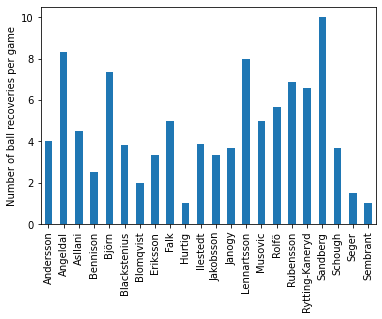

In [61]:
# keep only surnames
df_rec_tot['player_name'] = df_rec_tot['player_name'].apply(lambda x: str(x).split()[-1])
df_rec_per_match = df_rec_tot.groupby(['player_name','match_id']).count().x.reset_index()

# normalize recoveries
recs = df_rec_per_match.groupby(['player_name']).x.mean()
# make a histogram
ax = recs.plot.bar(recs)
# set labels
ax.set_xlabel("")
ax.set_ylabel("Number of ball recoveries per game")
plt.show()

#### Ball Recovieries leading to shot in counter attack

In [62]:
def get_danger_ball_recoveries(match_ids, timeframe=15):
    """
    Metric defined as ball recoveries leading to a shot on oppositions goal within a set timeframe.
    Default timeframe is 15 seconds.
    """

    danger_recoveries = pd.DataFrame()
    
    for idx in match_ids:
        # open the event data from each game 
        df = parser.event(idx)[0]
        for period in [1,2,3,4]:
            # keep only Swedens ball recoveries by Sweden
            mask_recs = mask_recovery = (df.team_name == team) & (df.type_name == 'Ball Recovery')
            # keep only necessary columns
            recs = df.loc[mask_recs, ['match_id', 'index', 'x', 'y', 'minute', 'second', 'player_name']]
            # keep only Swedens shots
            mask_shot = (df.team_name == team) & (df.type_name == 'Shot') & (df.period == period)
            # keep only necessary columns
            shots = df.loc[mask_shot, ['minute', 'second', 'outcome_name']]

            # convert shot time to seconds
            shot_times = shots['minute'] * 60 + shots['second']
            shot_window = timeframe
            # find starts of the window
            shot_start = shot_times - shot_window
            # condition to avoid negative shot starts
            shot_start = shot_start.apply(lambda i: i if i > 0 else (period - 1) * 45)
            # convert recovery time to seconds
            rec_times = recs['minute'] * 60 + recs['second']
            # check if pass is in any of the windows for this half
            rec_to_shot = rec_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

            # keep only danger passes
            danger_recoveries_period = recs.loc[rec_to_shot]

            # concatenate dataframe with previous ones to keep danger passes from the whole tournament
            danger_recoveries = pd.concat([danger_recoveries, danger_recoveries_period], ignore_index = True)
            
    return danger_recoveries

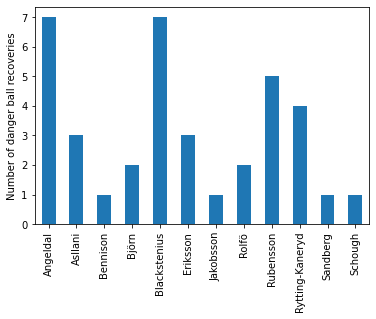

In [64]:
danger_recoveries = get_danger_ball_recoveries(match_ids, 15)
danger_recoveries['player_name'] = danger_recoveries['player_name'].apply(lambda x: str(x).split()[-1])

# normalize recoveries
d_recs = danger_recoveries.groupby(['player_name']).x.count()
# make a histogram
ax = d_recs.plot.bar(recs)
# set labels
ax.set_xlabel('')
ax.set_ylabel('Number of danger ball recoveries')
plt.show()

In [91]:
t, pvalue = ttest_1samp(d_recs, d_recs.Angeldal, alternative='less')

if pvalue < 0.05:
    print(f'P-value = {pvalue} - We reject null hypothesis - {key_player_name} won more Ball Recoveries than team average.')
else:
    print(f'P-value = {pvalue} - We do not reject null hypothesis - {key_player_name} did NOT win more Ball Recoveries than team average.')

P-value = 4.024488948967125e-05 - We reject null hypothesis - Angeldal won more Ball Recoveries than team average.


#### Ball Recovieries leading to goal in counter attack

In [67]:
df_all_goals = pd.DataFrame()

for match_id in match_ids:
    parser = Sbopen()
    df = parser.event(match_id)[0]

    df_goals = df.loc[(df.team_name == team) & (df.type_name == "Shot") & (df.outcome_name == 'Goal'), ['match_id', 'minute','second', 'outcome_name', 'player_name']]
    
    df_all_goals = pd.concat([df_all_goals, df_goals], ignore_index=True)

In [68]:
def recovery_to_goal(df_recovery, df_goals, timeframe=15):
    """
    Metric defined as ball recoveries leading to a within a set timeframe.
    Default timeframe is 15 seconds.
    """
    recovery_time = df_recovery['minute'] * 60 + df_recovery['second']
    goal_time_mask = df_goals['minute'] * 60 + df_goals['second']
    
    goal_time_frame = (goal_time_mask - recovery_time > 0) & (goal_time_mask - recovery_time < timeframe)
    
    df_goals = df_goals.loc[(df_goals['match_id'] == df_recovery['match_id']) & goal_time_frame]
    
    if len(df_goals) > 0:
        print(df_goals[['match_id', 'player_name']])
    
    return len(df_goals) > 0

In [72]:
df_danger_ang = danger_recoveries.loc[danger_recoveries.player_name == 'Angeldal']
df_danger_ang['goal_score'] = df_danger_ang.apply(lambda x: recovery_to_goal(x, df_all_goals,15), axis=1)

    match_id      player_name
17   3893796  Fridolina Rolfö


## Plot Angeldahl Ball Recoveries

In [82]:
player_name = 'Angeldal'
df_ang = df_rec_tot.loc[df_rec_tot.player_name == player_name, ['x', 'y', 'player_name']]

In [81]:
df_danger_ang['color'] = df_danger_ang.goal_score.apply(lambda x: "blue" if x else 'red')
df_danger_ang['alpha'] = df_danger_ang.goal_score.apply(lambda x: 1 if x else 0.7)

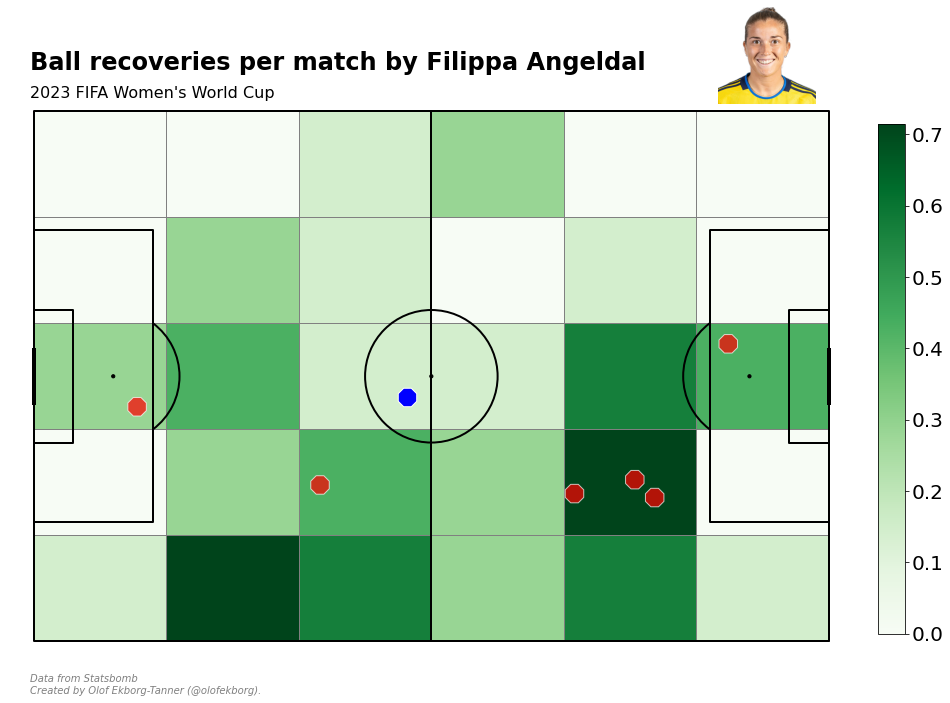

In [87]:
# plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
# get the 2D histogram 
bin_statistic = pitch.bin_statistic(df_ang.x, df_ang.y, statistic='count', bins=(6, 5), normalize=False)
# normalize by number of games
bin_statistic['statistic'] = bin_statistic['statistic']/no_games
# make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
# legend
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
ax_cbar.tick_params(labelsize=20)

# scatter Ball Recoveries
pitch.scatter(df_danger_ang.x, df_danger_ang.y, s=400, color=df_danger_ang.color, edgecolors='white', linewidth=1, alpha=df_danger_ang.alpha, marker='8', ax=ax['pitch'])

# add player image
ax2 = fig.add_axes([0.8,0.91,0.15,0.15]) # badge
ax2.axis('off')
url = 'https://b.fssta.com/uploads/application/soccer/headshots/91318.vresize.350.350.medium.13.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)


# adding title and subtitle
fig.text(0.05,0.92,'Ball recoveries per match by Filippa Angeldal\n', fontsize=24, fontweight='bold')
fig.text(0.05,0.92,'2023 FIFA Women's World Cup', fontsize=16, fontweight='regular')

fig.text(0.05, -0.0, 'Data from Statsbomb \n',
    fontstyle='italic',fontsize=10, color='gray')
fig.text(0.05, -0.0, 'Created by Olof Ekborg-Tanner (@olofekborg).',
    fontstyle='italic',fontsize=10, color='gray')


# plt.savefig('ball_recoveries.png', bbox_inches='tight')

plt.show()

## All Ball Recoveries in WWC23

In [89]:
#open the data
parser = Sbopen()
df_all_match = parser.match(competition_id=72, season_id=107)

In [90]:
# get all ball recoveries in tournament
df_all_br = pd.DataFrame()

for match_id in df_all_match.match_id.unique():
    parser = Sbopen()
    df = parser.event(match_id)[0]
    df_br = df.loc[(df.type_name == 'Ball Recovery'), ['x','y','player_name', 'position_name','match_id']]
    
    df_all_br = pd.concat([df_all_br, df_br], ignore_index=True)

In [93]:
# get average ball recoveries per player and match
br_per_match = df_all_br.groupby(['player_name','match_id']).count().x.reset_index()

br_avg = br_per_match.groupby('player_name').mean().reset_index()
br_avg['player_name'] = br_avg['player_name'].apply(lambda x: str(x).split()[-1])

In [94]:
angeldal_br = br_avg.loc[br_avg.player_name == key_player_name].x.iloc[0]

t, pvalue = ttest_1samp(br_avg.x, angeldal_br, alternative='less')

if pvalue < 0.05:
    print(f'P-value = {pvalue} - We reject null hypothesis - {key_player_name} won more Ball Recoveries than tournament average.')
else:
    print(f'P-value = {pvalue} -  We do not reject null hypothesis - {key_player_name} did NOT win more Ball Recoveries than tournament average')

P-value = 8.941593011743003e-163 - We reject null hypothesis - Angeldal won more Ball Recoveries than tournament average.


In [100]:
print(f'Angeldals ball recoveries pre match: {angeldal_br}')
print(f'Tournament average of ball recoveries per match: {br_avg.x.mean()}')
print(f'Standard deviation of ball recoveries per match: {br_avg.x.std()}')
print(f'90th quatinle for ball recoveries per match: {br_avg.x.quantile(q=0.9)}')

Angeldals ball recoveries pre match: 8.333333333333334
Tournament average of ball recoveries per match: 4.539063272367771
Standard deviation of ball recoveries per match: 2.3571509338002827
90th quatinle for ball recoveries per match: 7.725000000000002


### Midfielders only

In [108]:
df_all_br['position_name'] = df_all_br['position_name'].apply(lambda x: str(x).split()[-1])
df_mid = df_all_br.loc[df_all_br.position_name == 'Midfield']
br_per_match_mid = df_mid.groupby(['player_name','match_id']).count().x.reset_index()
br_per_match_mid['player_name'] = br_per_match_mid['player_name'].apply(lambda x: str(x).split()[-1])

In [109]:
br_avg_mid = br_per_match_mid.groupby('player_name').mean().reset_index()
br_avg_mid['player_name'] = br_avg_mid['player_name'].apply(lambda x: str(x).split()[-1])

In [112]:
angeldal_br_mid = br_avg_mid.loc[br_avg_mid.player_name == key_player_name].x.iloc[0]

t, pvalue = ttest_1samp(br_avg_mid.x, angeldal_br_mid, alternative='less')

if pvalue < 0.05:
    print(f'P-value = {pvalue} - We reject null hypothesis - {key_player_name} won more Ball Recoveries than tournament average for Midfielders.')
else:
    print(f'P-value = {pvalue} - We do not reject null hypothesis - {key_player_name} did NOT win more Ball Recoveries than tournament average for Midfielders.')

P-value = 1.513539107627741e-64 - We reject null hypothesis - Angeldal won more Ball Recoveries than tournament average for Midfielders.


In [114]:
print(f'Angeldals ball recoveries pre match: {angeldal_br}')
print(f'Tournament average of ball recoveries per match among midfielders: {br_avg_mid.x.mean()}')
print(f'Standard deviation of ball recoveries per match among midfielders: {br_avg_mid.x.std()}')
print(f'90th quatinle for ball recoveries per match among midfielders: {br_avg_mid.x.quantile(q=0.9)}')

Angeldals ball recoveries pre match: 8.333333333333334
Tournament average of ball recoveries per match among midfielders: 4.460482118158466
Standard deviation of ball recoveries per match among midfielders: 2.5559653741255746
90th quatinle for ball recoveries per match among midfielders: 8.0
